# Tutorial 2: Social media & valuation of landscapes

Within this tutorial, we will work with the Flickr photo database to better understand how people value specific land use types. We will learn how to extract information from Flickr, how you can explore and visualize this, and how to use it for some basic analysis.

### Important before we start
---
Make sure that you save this file before you continue, else you will lose everything. To do so, go to **Bestand/File** and click on **Een kopie opslaan in Drive/Save a Copy on Drive**!

Now, rename the file into Week4_Tutorial1.ipynb. You can do so by clicking on the name in the top of this screen.


## Learning Objectives
<hr>

- To understand how we can use public data to better understand people's preferences for leisure.
- To know how to extract data from Flickr using an API.
- To know how to clean and prepare raw data for analysis.
- To know how to cluster geospatial information.
- To visualize clusters and point data in a meaningful way.
- To know how to combine different spatial datasets to gain additional insights.

<h2>Tutorial Outline<span class="tocSkip"></span></h2>
<hr>
<div class="toc"><ul class="toc-item">
<li><span><a href="#1.-Introducing the packages" data-toc-modified-id="1.-Introducing-the-packages-2">1. Introducing the packages</a></span></li>
<li><span><a href="#2.-Extract data from Flickr" data-toc-modified-id="2.-Extracting-flickr-data-3">2. Extract data from Flickr</a></span></li>
<li><span><a href="#3.-Explore the data" data-toc-modified-id="3.-Explore-Data-4">3. Explore the data</a></span></li>
<li><span><a href="#4.-Clustering of data" data-toc-modified-id="4.-Cluster-data-5">4. Clustering of data</a></span></li>
<li><span><a href="#5.-Do people prefer certain land uses?" data-toc-modified-id="5.-Analyze-buildings-6">5. Do people prefer certain land uses? </a></span></li></ul></div>

## 1.Introducing the packages
<hr>

Within this tutorial, we are going to make use of the following packages: 

[**OSMnx**](https://osmnx.readthedocs.io/) is a Python package that lets you download geospatial data from OpenStreetMap and model, project, visualize, and analyze real-world street networks and any other geospatial geometries. You can download and model walkable, drivable, or bikeable urban networks with a single line of Python code then easily analyze and visualize them. You can just as easily download and work with other infrastructure types, amenities/points of interest, building footprints, elevation data, street bearings/orientations, and speed/travel time.

[**flickrapi**](https://stuvel.eu/flickrapi-doc/index.html) is a Python interface to the Flickr API. It includes support for authorized and non-authorized access, uploading and replacing photos, and all Flickr API functions.

*We will first need to install these packages in the cell below. Uncomment them to make sure we can pip install them*

In [ ]:
#!pip install flickrapi
#!pip install osmnx
#!pip install geopandas

Now we will import these packages in the cell below:

In [64]:
import flickrapi
import json
import pygeos
import pandas as pd
import contextily as cx
import geopandas as gpd
import osmnx as ox
import numpy as np

from datetime import datetime

## 2. Extract data from Flickr
<hr>

To extract data from Flicker, we will use their **API**. This is an acronym for application programming interface. It is a software intermediary that allows two applications to talk to each other. APIs are an accessible way to extract and share data within and across organizations. APIs are all around us. Every time you use a rideshare app, send a mobile payment, or change the thermostat temperature from your phone, you’re using an API.

However, before we can access this **API**, we need to take a few steps. Most importantly, we need to register ourselves on the [Flickr](https://www.flickr.com/) portal. To do so, we need to register, as explained in the video clip below:

<img src="https://github.com/ElcoK/BigData_AED/blob/main/_static/images/Flickr_registration.gif?raw=1" class="bg-primary mb-1">
<br>

Now, the next step is to access the API. You can now login on the website of [Flickr](https://www.flickr.com/), and go to the **API** part of the [website](https://www.flickr.com/services/apps/create/apply/?).

Now click on `APPLY FOR A NON-COMMERCIAL KEY` and just fill in some information about the course. The name of the App can be something random and related to our big data course, and you just need to fill in two lines of text to describe what you want to do. As soon as you click `SUBMIT`, you will see a generated **api_key** and an **api_secret**. Fill those in below.

In [491]:
api_key = 'd65f682f6f7e8a02a3db8cfbe3c29b15'
api_secret='09f3aa61233e2e11'

flickr = flickrapi.FlickrAPI(api_key, api_secret, cache=True)

### Prepare data extraction

Before we get started with the extraction of data, we need to specify again an area of interest we want to focus on. In the cell below, you will now read "Ameland, The Netherlands". Change this to any random or municipality in the Netherlands that (1) you can think of and (2) will work. 

In some cases, the function does not recognize the location. You could either try a different phrasing or try a different location. Many parts of the Netherlands should work. It is also fine to use an area outside of the Netherlands. I would make sure to not make it too large, as it will take a long time to extract the photos.

In [434]:
place_name = "Ameland, The Netherlands"
area = ox.geocode_to_gdf(place_name)

Now let us visualize the bounding box of the area, similar to some of our previous tutorials.

Text(0.5, 1.0, 'Ameland, The Netherlands. Total area: 161 km2')

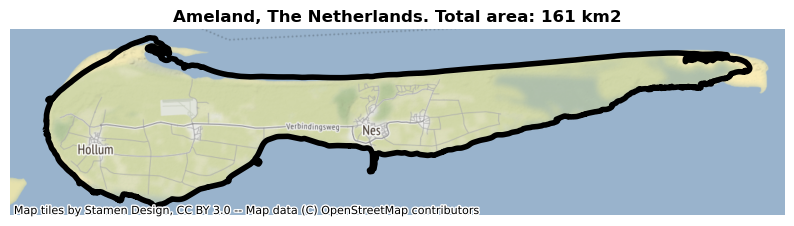

In [435]:
area_to_check = area.to_crs(epsg=3857)
ax = area_to_check.plot(figsize=(10, 10), color="none", edgecolor="k", linewidth=4)
ax.set_xticks([])
ax.set_yticks([])
ax.set_axis_off()
cx.add_basemap(ax, zoom=12)

size = int(area_to_check.area/1e6)

ax.set_title("{}. Total area: {} km2".format(place_name,size),fontweight='bold')

### Data extraction

To extract the metadata of the photos from Flickr, we are going to use the `.walk()` function. This function will return a list of photos matching some criteria. It allows you to search photos based on location, date, tag and so on.

In our case, we are state that we want to find all photos, no matter how they are tagged. This is defined through `tag_mode=all`. Moreover, as you will see, we also specify that we want some extra information. More specifically, we ask for the `geo(location)`, `tags`, `date_taken` and the `url_m` of a photo.

We use a bounding box `bbox` to make sure we only select photos from our region of interest. The input requires our bounding box to me in a string format. So let's do that first.

In [437]:
bbox_string = ",".join([str(x) for x in area.bounds.values[0]])

And now we can extract all the photos. We collect all of them in a list, through the `.append()` function

In [438]:
collect_pictures = []
for photo in flickr.walk(tag_mode='all',
                         #tags='nature',
                         bbox=bbox_string,extras='geo,tags,date_taken,url_m'):
    
    get_attributes = photo.attrib
    collect_pictures.append([get_attributes['id'],
                             get_attributes['datetaken'],
                             get_attributes['tags'],
                             get_attributes['latitude'],
                             get_attributes['longitude']])

## 3. Explore the data
<hr>
Now we have extracted the data and, let's explore (and clean) this data a bit more. The convenient thing of having everything stored in a list, is that we can easily turn this into a pandas DataFrame.

In [439]:
df = pd.DataFrame(collect_pictures,columns=['id','datetaken','tags','latitude','longitude'])

Now let's explore the data a little bit:

In [442]:
df.head()

,id,datetaken,tags,latitude,longitude
0,52637307998,2022-08-08 14:59:24,ameland meer europa wasser watt fortbewegungsm...,53.442808,5.737283
1,52633905369,2022-08-13 17:20:14,img4088 13082022 nederland netherlands ameland...,53.441900,5.613400
2,52631247150,2023-01-11 14:23:22,isle island eiland waddeneiland ameland friesl...,53.448148,5.630857
3,52624908216,2022-08-08 11:40:26,jahreszeiten leuchtturm aussicht ameland fries...,53.454041,5.638633
4,52622686386,2023-01-12 05:04:38,eglise nederland kerk foto hccity oud church old,53.440180,5.634881


And let's see if everything is stored in a format in which we can work with:

In [446]:
df.dtypes

id           object
datetaken    object
tags         object
latitude     object
longitude    object
dtype: object

We would expect floating values for the **latitude** and **longitude**, and a *datetime* object for the **datetaken**. Let's have a look how these are stored: 

In [448]:
df.longitude.iloc[0]

'5.737283'

Aha! Strings. It will be difficult to convert strings into proper geometries, so let's convert these columns to floating values, and convert them to **points** using `pygeos.points()`. As you will see, we use a [list comprehension](https://docs.python.org/3/tutorial/datastructures.html#list-comprehensions) to do so. The input for `pygeos.points()` is a list or numpy array, in which each element contains a *longitude* and a *latitude*. To make sure we have that, we create this `list` using the [zip](https://docs.python.org/3.3/library/functions.html#zip) function in Python.

In [449]:
df['longitude'] = df['longitude'].astype(float)
df['latitude'] = df['latitude'].astype(float)
df['geometry'] = [pygeos.points(x[0],x[1]) for x in list(zip(df['longitude'],df['latitude']))]

Now let's convert the **datetaken** column into a *datetime* type, so we can extract specific years or days. 

In [450]:
df['datetaken'] = df.datetaken.apply(lambda x : datetime.fromisoformat(x))
df['year'] = df.datetaken.dt.year

As we are dealing with spatial data, it would be nice to plot this information on a map. To do so, we convert our `pandas.DataFrame` into a `geopandas.GeoDataFrame`. Moreover, we have to specify the coordinate reference system. Given that we have a global dataset, it makes most sense to use **epsg:4326**.

In [452]:
gdf = gpd.GeoDataFrame(df.copy())
gdf.crs = 'epsg:4326'

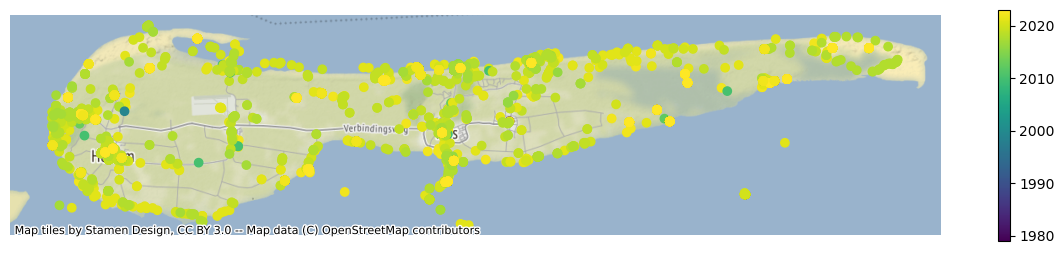

In [457]:
gdf_to_plot = gdf.to_crs(epsg=3857)

ax = gdf_to_plot.plot(column='year',figsize=(15, 3),legend=True)
ax.set_xticks([])
ax.set_yticks([])
ax.set_axis_off()
cx.add_basemap(ax, zoom=12)

#ax.set_title("{}. Total area: {} km2".format(place_name,size),fontweight='bold')

Let's have a look how all these photos are tagged. And whether we can actually do something with this information.

In [459]:
gdf['tags']

0       ameland meer europa wasser watt fortbewegungsm...
1       img4088 13082022 nederland netherlands ameland...
2       isle island eiland waddeneiland ameland friesl...
3       jahreszeiten leuchtturm aussicht ameland fries...
4        eglise nederland kerk foto hccity oud church old
                              ...                        
6995    aussicht ameland friesland europa meer wasser ...
6996    himmel jahreszeiten sonnenuntergang pflanzen a...
6997    leuchtturm ameland farbe europa jahreszeiten n...
6998    europa ameland friesland jahreszeiten wattenme...
6999    jahreszeiten leuchtturm aussicht ameland fries...
Name: tags, Length: 7000, dtype: object

This looks like a mess. It seems we have some work to do to be able to use some of this. Lets get an overview of all the tags and get an idea how often certain tags are used.

In [463]:
find_all_tags = []
for row in gdf.tags:
    find_all_tags.append(row.split())
    
all_tags = [item for sublist in find_all_tags for item in sublist]

pd.Series(all_tags).value_counts().head(50)

So we see that quite a lot of the tags don't really say much about the area or why people might visit the area. Let's give it a go by just trying to see how many pictures are tagged in something linked to nature. Add more words if you believe you can identify more in the previous overview.

In [472]:
def find_nature_tags(row):
    matches = ["seehund", "zeehond","natuur","nature","natur","landschaft","strand","beach","zee","sea","meer","animal","bird"]

    if any(x in row for x in matches):
        return 'yes'
    
gdf['nature'] = gdf.tags.apply(lambda x: find_nature_tags(x))

Let's count them.

In [478]:
len(gdf.loc[gdf.nature=='yes'])

3686

And let's only plot those points on a map

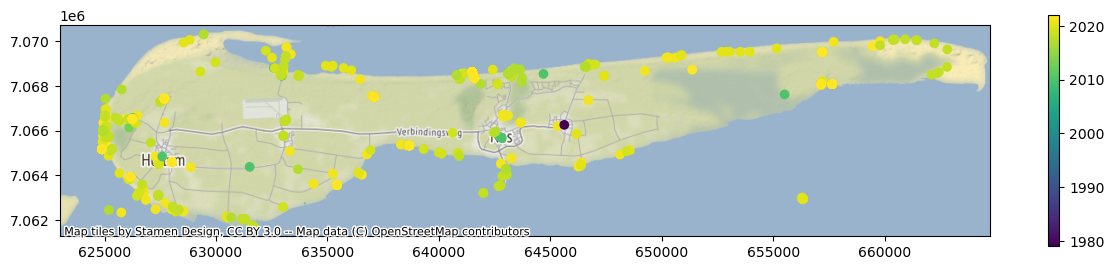

In [492]:
gdf_to_plot = gdf.to_crs(epsg=3857)
gdf_to_plot = gdf_to_plot.loc[gdf_to_plot.nature == 'yes']
gdf_to_plot.reset_index(drop=True,inplace=True)

ax = gdf_to_plot.plot(column='year',figsize=(15, 3),legend=True)
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_axis_off()
cx.add_basemap(ax, zoom=12)

#ax.set_title("{}. Total area: {} km2".format(place_name,size),fontweight='bold')

## 4. Clustering of data
<hr>

As it is pretty difficult to see any patterns on the maps above, let's try to cluster some of this information and see if this helps us to better understand why people choose to visit certain locations in the area.

The most simple way would be to collect all points within a grid. The `create_grid()` function below will help us to create a evenly-distributed grid within any given area. So let's use that!

In [ ]:
def create_grid(bbox,height):
    """Create a vector-based grid
    Args:
        bbox ([type]): [description]
        height ([type]): [description]
    Returns:
        [type]: [description]
    """    

    # set xmin,ymin,xmax,and ymax of the grid
    xmin, ymin = pygeos.total_bounds(bbox)[0],pygeos.total_bounds(bbox)[1]
    xmax, ymax = pygeos.total_bounds(bbox)[2],pygeos.total_bounds(bbox)[3]
    
    #estimate total rows and columns
    rows = int(np.ceil((ymax-ymin) / height))
    cols = int(np.ceil((xmax-xmin) / height))

    # set corner points
    x_left_origin = xmin
    x_right_origin = xmin + height
    y_top_origin = ymax
    y_bottom_origin = ymax - height

    # create actual grid
    res_geoms = []
    for countcols in range(cols):
        y_top = y_top_origin
        y_bottom = y_bottom_origin
        for countrows in range(rows):
            res_geoms.append((
                ((x_left_origin, y_top), (x_right_origin, y_top),
                (x_right_origin, y_bottom), (x_left_origin, y_bottom)
                )))
            y_top = y_top - height
            y_bottom = y_bottom - height
        x_left_origin = x_left_origin + height
        x_right_origin = x_right_origin + height

    return pygeos.polygons(res_geoms)

In [357]:
coords = df[['latitude', 'longitude']].to_numpy()

In [390]:
coords = np.array(list(zip(gdf_to_plot.geometry.y.values,gdf_to_plot.geometry.x.values)))

In [391]:
coords

array([[7065159.4585024 ,  624880.82961896],
       [7067428.83008726,  627689.75433015],
       [7068624.80559391,  641492.14667412],
       ...,
       [7068373.51800243,  641579.64379388],
       [7063911.8701792 ,  626161.89431901],
       [7068358.3736919 ,  641587.99275569]])

In [431]:
epsilon = 1000 #/ kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=5, algorithm='ball_tree').fit((coords)) #, metric='haversine'
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 21


In [432]:
clusters

0     [[7065159.4585024, 624880.8296189619], [706391...
1     [[7067428.830087262, 627689.7543301485], [7067...
2     [[7068624.8055939125, 641492.1466741158], [706...
3     [[7063553.290208715, 635422.7853970849], [7063...
4     [[7069519.895295769, 657189.7533488383], [7069...
5     [[7068079.050478185, 657638.7048552077], [7068...
6     [[7067514.0773409745, 637096.2513021801], [706...
7     [[7065329.157618469, 638671.422096905], [70653...
8     [[7068686.132939823, 643270.0302615751], [7068...
9     [[7064523.866620934, 642772.0981792568], [7066...
10    [[7064016.887284922, 636542.1028770113], [7064...
11    [[7069787.301186925, 659442.5258840219], [7069...
12    [[7068727.641351335, 651355.2761973813], [7068...
13    [[7068490.934131044, 632913.0874771505], [7068...
14    [[7068635.837002284, 629300.2134034549], [7069...
15    [[7061926.523372786, 632269.4381813838], [7062...
16    [[7069529.618988529, 652888.7021830587], [7069...
17    [[7068698.660230339, 636067.1026097963], [

<AxesSubplot:>

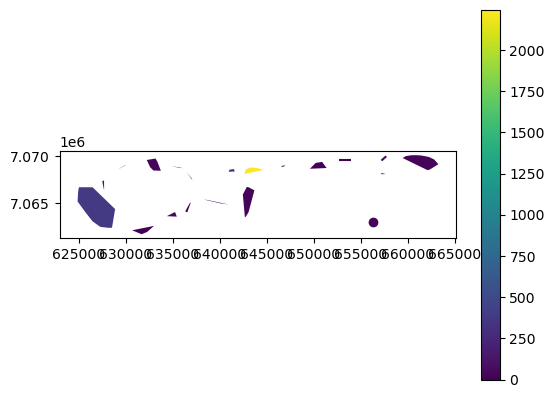

In [433]:
cluster_gdf = gpd.GeoDataFrame(clusters.apply(lambda x : pygeos.convex_hull(pygeos.multipoints(np.flip(x,axis=1)))),columns=['geometry'])
cluster_gdf['cluster_size'] = clusters.apply(lambda x : len(x))
cluster_gdf.plot(column='cluster_size',legend=True)

## 5. Do people prefer certain land uses?
<hr>

We already started to understand our data a little bit better. However, it would be interesting to combine this with some land-use information, to see if we can find some patterns over there.